## Corporate Bankruptcy Prediction: Logistic Regression

### 1. Imports

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipynb.fs.full.prep_datasets import pipeline_preparation
from ipynb.fs.full.feature_eng import pipeline_feature_eng
from ipynb.fs.full.feature_eng import pipeline_logreg

# preprocessing imports
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.model_selection import train_test_split

# additional imports
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectFromModel

# classifier imports
from sklearn.linear_model import Lasso, LogisticRegression

# performance measure imports
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### 2. Preprocessing and feature engineering

In [2]:
# reading dataset, preprocessing and feature engineering
df = pd.read_csv("final_df_dec.csv")
df, df_2016 = pipeline_preparation(df)
df, X_train, X_test, y_train, y_test = pipeline_feature_eng(df)
X_train, X_test, y_train, y_test = pipeline_logreg(X_train, X_test, y_train, y_test)

df.head()

,oprev_turn_2016,oprev_turn_2015,oprev_turn_2014,oprev_turn_2013,oprev_turn_2012,netinc_2016,netinc_2015,netinc_2014,netinc_2013,netinc_2012,...,wc_2015,wc_2014,wc_2013,wc_2012,ebit_2016,ebit_2015,ebit_2014,ebit_2013,ebit_2012,bankrupt
0,-766.35,-7906.91,5816.03,18821.76,57891.48,-1812.06,-9470.22,868.65,7543.16,43498.62,...,0.45,0.0,0.0,0.0,-5824.87,-13714.53,-574.51,10786.05,31216.17,0
1,-38066.54,6595.85,6538.46,6033.35,-16398.63,6635.53,-117844.28,-12043.21,-65075.98,-62549.21,...,0.45,0.0,0.0,0.0,-42123.12,5689.15,5772.95,4640.32,-17129.81,0
2,-73110.61,-73994.18,-219163.04,-90426.31,-65.87,-145848.42,-141530.59,-280881.84,-203076.12,-146.32,...,0.45,0.0,0.0,0.0,-145182.90,-140783.81,-280590.36,-146308.52,-146.32,0
3,-28482.50,-32000.20,2570.26,9133.93,6622.08,-32358.51,-34233.79,118.54,5814.55,5723.77,...,0.45,0.0,0.0,0.0,-30769.77,-32322.32,2278.59,8806.28,6533.03,0
4,-2578.17,7294.13,0.01,4826.16,0.00,-40568.90,-31819.79,-37698.85,-77461.00,-11.65,...,0.45,0.0,0.0,0.0,-12652.25,-14650.90,-17555.11,-55605.31,-11.65,0


### 3. Fitting the model

According to prior analysis the following classifier are the best estimator.

In [3]:
# best classifier of Logistic Regression
best_classifier_logreg = LogisticRegression(C=7,class_weight="balanced",max_iter=80,multi_class="auto",
                                            n_jobs=-1,penalty="l2",solver="saga",verbose=0)

In [4]:
# function for fitting the model
def fit_model(best_classifier, df, X_train, y_train):
    # fiting classifier
    cols = df.columns[0:-1]
    best_estim = best_classifier.fit(X_train, y_train)
    # cross validation score
    scores = cross_val_score(best_classifier, X_train, y_train, cv=5, scoring="roc_auc")
    print("CV Mean:",scores.mean())
    return best_estim

I am now fitting the best estimator with the training data. The test data was put aside. 

In [5]:
# training the data for Logistic Regression model
best_estim_logreg = fit_model(best_classifier_logreg, df, X_train, y_train)

CV Mean: 0.8215959483454693


### 4. Coefficients

In [6]:
# colculating coefficients logistic regression
def coefficients(best_estim):
    cols = df.columns[0:-1]
    coeff_output = pd.DataFrame({"feature":cols,
                                 "coefficient":best_estim.coef_[0]})
    return coeff_output

In [7]:
# coefficient output top 10
coeff_output = coefficients(best_estim_logreg)
coeff_output.sort_values(by=["coefficient"], ascending=False).head(5)

,feature,coefficient
11,totass_2015,0.471837
117,numofempl_2015,0.413567
125,sales_2012,0.263196
2,oprev_turn_2014,0.219752
12,totass_2014,0.213423


In [8]:
# coefficient output bottom 10
coeff_output.sort_values(by=["coefficient"], ascending=False).tail(5)

,feature,coefficient
72,liqr_2012,-0.429840
6,netinc_2015,-0.516671
121,sales_2016,-0.523971
0,oprev_turn_2016,-0.561352
132,ebit_2015,-0.563105


### 5. Prediction

In [9]:
# function for prediction
def prediction(best_estim, X_test, y_test):
    # predict on the trained classifier
    y_test_predicted = best_estim.predict(X_test)
    y_test_prob_pred = best_estim.predict_proba(X_test)[::,1]
    return y_test_predicted, y_test_prob_pred

By means of the fitted model with the best estimator, I am now predicting on the test data and I am gonna evaluate these predictions. 

In [10]:
# predicting on test data Logistic Regression model
y_test_predicted_logreg, y_test_prob_pred_logreg = prediction(best_estim_logreg, X_test, y_test)

### 6. Performance measurement

In [11]:
# function for performance measurement
def performance_measure(y_test, y_test_predicted, y_test_prob_pred):
    
    # plotting the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob_pred)
    plt.plot(fpr, tpr, c="dimgrey",label="logistic regression classifier")
    plt.plot([0, 1], [0, 1], c="cornflowerblue", linestyle='--', label="random guess classifier")
    plt.title("ROC Curve of Logistic Regression Classifier")
    plt.xlabel("False Positive Rate - Specificity")
    plt.ylabel("True Positive Rate - Sensitivity")
    plt.legend()
    plt.grid(True)
    plt.show()  
    
    # AUC
    auc = roc_auc_score(y_test, y_test_predicted)
    print("AUC:",round(auc,2))
    return auc

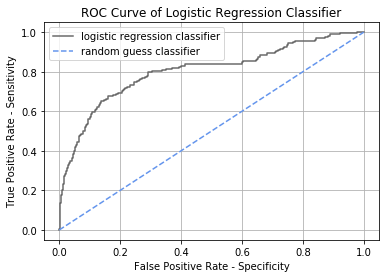

AUC: 0.75


0.7494727637267651

In [12]:
# performance measure Logistic Regression
performance_measure(y_test, y_test_predicted_logreg, y_test_prob_pred_logreg)

In [13]:
# function for confusion matrix with individual decision-threshold
def confusion(y_test, y_test_prob_pred, threshold):
    
    predicted = (y_test_prob_pred >= threshold).astype('int')
    conf = confusion_matrix(y_test, predicted)
    plt.figure(figsize=(7,5))
    sns.heatmap(pd.DataFrame(conf), annot=True, cmap="Blues" ,fmt='g')
    plt.xlabel("predicted values")
    plt.ylabel("actual values")
    plt.title("Confusion Matrix for a {} decision-threshold".format(threshold))
    plt.show()
    
    TP = conf[1,1]
    TN = conf[0,0]
    FP = conf[0,1]
    FN = conf[1,0]
        
    # sensitivity/ recall_score
    print("Sensitivity:", TP/float(TP+FN)) 
       
    # specificity
    print("Specificity:", TN/float(TN+FP))

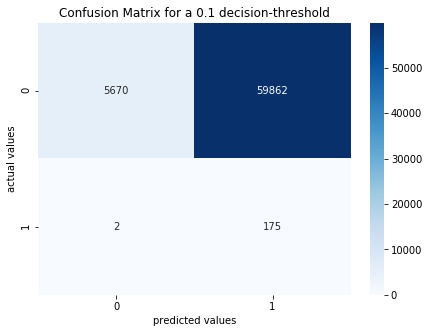

Sensitivity: 0.9887005649717514
Specificity: 0.08652261490569493


In [14]:
# confusion matrix for 0.1 decision-threshold
confusion(y_test, y_test_prob_pred_logreg, 0.1)

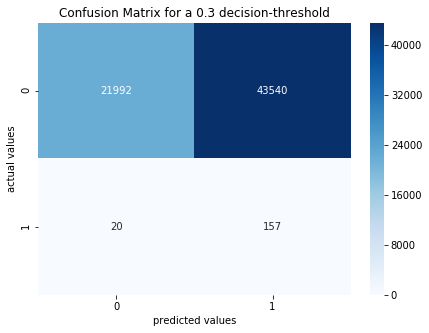

Sensitivity: 0.8870056497175142
Specificity: 0.33559177195873774


In [15]:
# confusion matrix for 0.3 decision-threshold
confusion(y_test, y_test_prob_pred_logreg, 0.3)

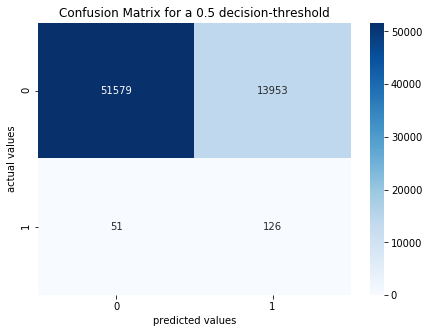

Sensitivity: 0.711864406779661
Specificity: 0.7870811206738693


In [16]:
# confusion matrix for 0.5 decision-threshold
confusion(y_test, y_test_prob_pred_logreg, 0.5)

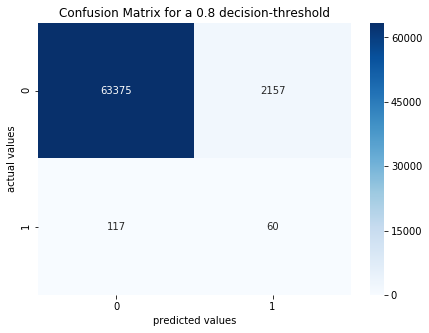

Sensitivity: 0.3389830508474576
Specificity: 0.9670847830067754


In [17]:
# confusion matrix for 0.8 decision-threshold
confusion(y_test, y_test_prob_pred_logreg, 0.8)